In [36]:
# Upwelling Index (UI) and Correlation Analysis

# This notebook reproduces the computation and visualization of:
# - Geostrophic Coastal Upwelling Index (GCUI)
# - Ekman Coastal Upwelling Index (ECUI)
# - Combined Upwelling Index (CUI)
# and explores their correlations with:
# - Sea Surface Height (SSH)
# - Sea Surface Temperature (SST)
# - Sea Surface Salinity (SSS)

# The analysis covers **2010–2017**, consistent with the upwelling period of interest.


In [59]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
import xarray as xr
import numpy as np
import pandas as pd
import os
import datetime
import shutil
import glob
import calendar
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tempfile
import numpy as np
from scipy import stats
from PIL import Image
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import string

In [38]:
## Step 1: Define dataset paths and basic setup
# We load the various datasets used for the upwelling correlation analysis.
# The datasets include SSH, SST, SSS, and the pre-computed Upwelling Index files.


In [39]:
# List of month names for later use in plotting
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Dataset paths
wind_data = '../datasets/data_t.nc'
current_data = '../datasets/cmems_obs-mob_glo_phy-cur_my_0.25deg_P1M-m_1740187181287.nc'
ssh_data = '../datasets/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_1740483994742.nc'
sst_data = '../datasets/MUR_Monthly_SST_.nc'
sss_data = '../datasets/cmems_obs-mob_glo_phy-sss_my_multi_P1M_1740653508523.nc'

# Open the Upwelling Index dataset
cui_ds = xr.open_dataset('..//datasets/CUI_2010_2017.nc')


In [40]:
## Step 2: Compute GCUI, ECUI, and Combined Upwelling Index (CUI)

# We compute:
# - Mean values along latitude for GCUI and ECUI.
# - Multiply by 86400 to convert from m/s to m/day (if derived from currents).
# - Combine both indices to obtain the total upwelling index (CUI = ECUI + GCUI).


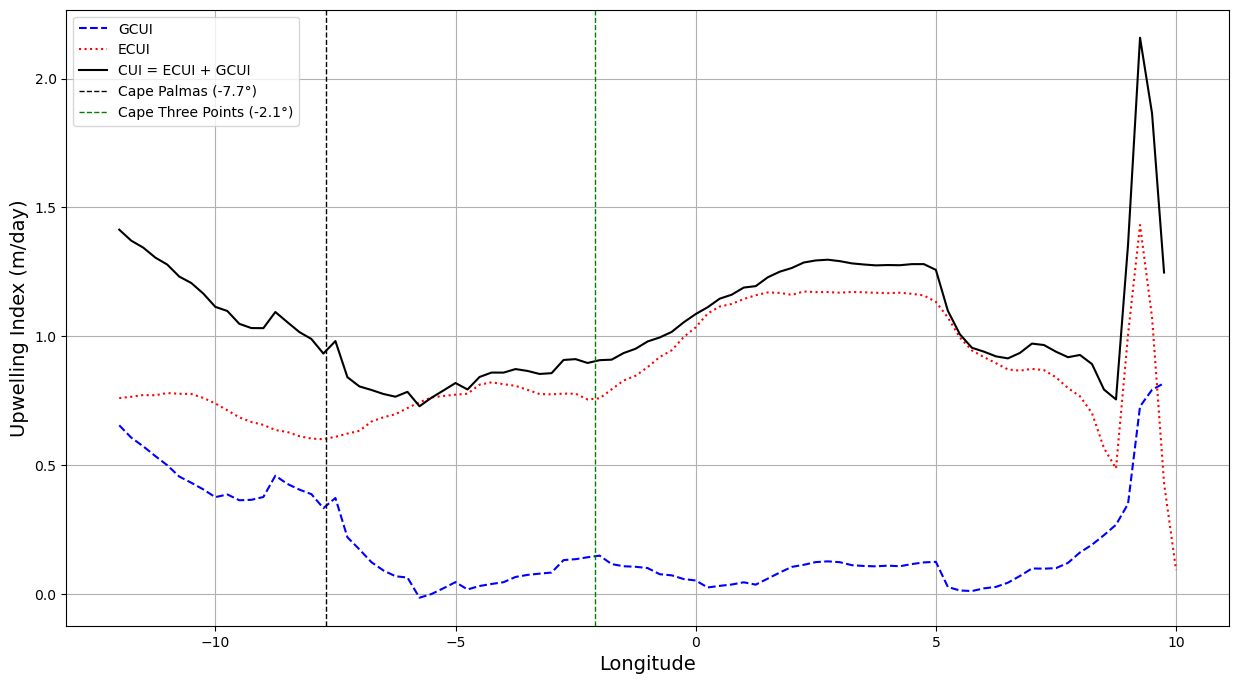

In [41]:
# Average along latitude
cui_mean = cui_ds.mean(dim=['latitude'])

# Compute means over time
gcui_mean = cui_mean['GCUI'].mean(dim='time', skipna=True) * 86400
ecui_mean = cui_mean['ECUI'].mean(dim='valid_time', skipna=True) * 86400

# Combined CUI
cui_total = ecui_mean + gcui_mean

# Plot GCUI, ECUI, and CUI across longitude
plt.figure(figsize=(15, 8))
plt.plot(cui_mean['longitude'], gcui_mean, label="GCUI", linestyle="--", color="blue")
plt.plot(cui_mean['longitude'], ecui_mean, label="ECUI", linestyle=":", color="red")
plt.plot(cui_mean['longitude'], cui_total, label="CUI = ECUI + GCUI", linestyle="-", color="black")

# Add key geographical landmarks
cape_palmas_lon = -7.7
cape_three_points_lon = -2.1
plt.axvline(x=cape_palmas_lon, color='black', linestyle='--', linewidth=1, label='Cape Palmas (-7.7°)')
plt.axvline(x=cape_three_points_lon, color='green', linestyle='--', linewidth=1, label='Cape Three Points (-2.1°)')

# Labels and legend
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Upwelling Index (m/day)", fontsize=14)
plt.legend()
plt.grid()
plt.savefig("figures/CUI.png")
plt.show()


In [42]:
## Step 3: Load and subset the ocean datasets

# We now open and subset the SSH, SST, and SSS datasets to match the 2010–2017 period.
# For SSS, we take the mean over depth since it is often 3D (lon, lat, depth, time).


In [43]:
# Open and subset ocean datasets
ssh_data_open = xr.open_dataset(ssh_data)
sst_data_open = xr.open_dataset(sst_data)
sss_data_open = xr.open_dataset(sss_data).mean(dim='depth')

# Define and apply time range
time_range = slice("2010-01-01", "2017-12-31")
ssh_ds = ssh_data_open.sel(time=time_range)
sst_ds = sst_data_open.sel(time=time_range)
sss_ds = sss_data_open.sel(time=time_range)


In [44]:


# Extract key variables
ECUI = cui_ds['ECUI'] *86400
GCUI = cui_ds['GCUI'] *86400
#CUI = ECUI + GCUI  # Compute total upwelling index

SSH = ssh_ds['adt']  # Adjust variable name if needed
SST = sst_ds['sst']  # Adjust variable name if needed
SSS = sss_ds['sos']  # Adjust variable name if needed

In [30]:
## Step 4: Interpolate SSH, SST, and SSS to the CUI grid

# All datasets are interpolated to the spatial and temporal grid of the CUI dataset.
# This ensures alignment for correlation computation.


In [45]:
def interpolate_to_cui(ds, cui_ds):
    """Interpolates a dataset to match the grid of the CUI dataset."""
    return ds.interp(longitude=cui_ds.longitude, latitude=cui_ds.latitude, time=cui_ds.valid_time)

SSH_interp = interpolate_to_cui(SSH, cui_ds)
SST_interp = interpolate_to_cui(SST, cui_ds)
SSS_interp = interpolate_to_cui(SSS, cui_ds)


In [46]:
## Step 5: Ensure Consistent Time Dimensions

# Some datasets use `time`, others use `valid_time`.  
# We standardize all to a single `time` dimension for alignment.


In [47]:
def ensure_time_dim(da):
    """Ensures the data array has a consistent 'time' dimension."""
    if 'valid_time' in da.coords and 'valid_time' not in da.dims:
        da = da.drop_vars('valid_time')
    if 'time' in da.dims:
        return da
    if 'valid_time' in da.dims:
        if 'time' in da.coords and 'time' not in da.dims:
            da = da.drop_vars('time')
        return da.rename({'valid_time': 'time'})
    raise ValueError("No time-like dimension found in DataArray.")

ECUI_t = ensure_time_dim(cui_ds['ECUI'])
GCUI_t = ensure_time_dim(cui_ds['GCUI'])
SSH_t  = ensure_time_dim(SSH_interp)
SST_t  = ensure_time_dim(SST_interp)
SSS_t  = ensure_time_dim(SSS_interp)


In [48]:
## Step 6: Compute Correlations and Test Significance

# We calculate the Pearson correlation coefficient between:
# - ECUI and each of SSH, SST, and SSS
# - GCUI and each of SSH, SST, and SSS

# We then test the statistical significance using the Student-t test with 95% confidence.


In [49]:
def corr_aligned(a, b):
    """Compute correlation after aligning on time."""
    a, b = xr.align(a, b, join='inner')
    if 'depth' in a.dims: a = a.mean('depth')
    if 'depth' in b.dims: b = b.mean('depth')
    return xr.corr(a, b, dim='time')

# Compute correlations
correlation_ECUI_SSH = corr_aligned(ECUI_t, SSH_t)
correlation_ECUI_SST = corr_aligned(ECUI_t, SST_t)
correlation_ECUI_SSS = corr_aligned(ECUI_t, SSS_t)

correlation_GCUI_SSH = corr_aligned(GCUI_t, SSH_t)
correlation_GCUI_SST = corr_aligned(GCUI_t, SST_t)
correlation_GCUI_SSS = corr_aligned(GCUI_t, SSS_t)


In [50]:
### Step 7: Apply a significance mask
# We use a p-value test (α = 0.05) to retain only statistically significant correlations.


In [51]:
def correlation_significance_test(correlation_map, n):
    """Return a boolean mask of significant correlations at α = 0.05."""
    df = n - 2
    t_vals = correlation_map * np.sqrt(df / (1 - correlation_map**2))
    p_vals = 2 * (1 - stats.t.cdf(np.abs(t_vals), df))
    sig_mask = p_vals < 0.05
    return sig_mask, p_vals

sig_ECUI_SSH, _ = correlation_significance_test(correlation_ECUI_SSH, n=96)
sig_ECUI_SST, _ = correlation_significance_test(correlation_ECUI_SST, n=96)
sig_ECUI_SSS, _ = correlation_significance_test(correlation_ECUI_SSS, n=96)

sig_GCUI_SSH, _ = correlation_significance_test(correlation_GCUI_SSH, n=96)
sig_GCUI_SST, _ = correlation_significance_test(correlation_GCUI_SST, n=96)
sig_GCUI_SSS, _ = correlation_significance_test(correlation_GCUI_SSS, n=96)


In [52]:
## Step 8: Visualize Correlation Maps

# Each panel shows spatial correlations between the Upwelling Indices (ECUI, GCUI)  
# and the ocean variables (SSH, SST, SSS).  
# Hatched areas indicate statistically significant correlations (p < 0.05).


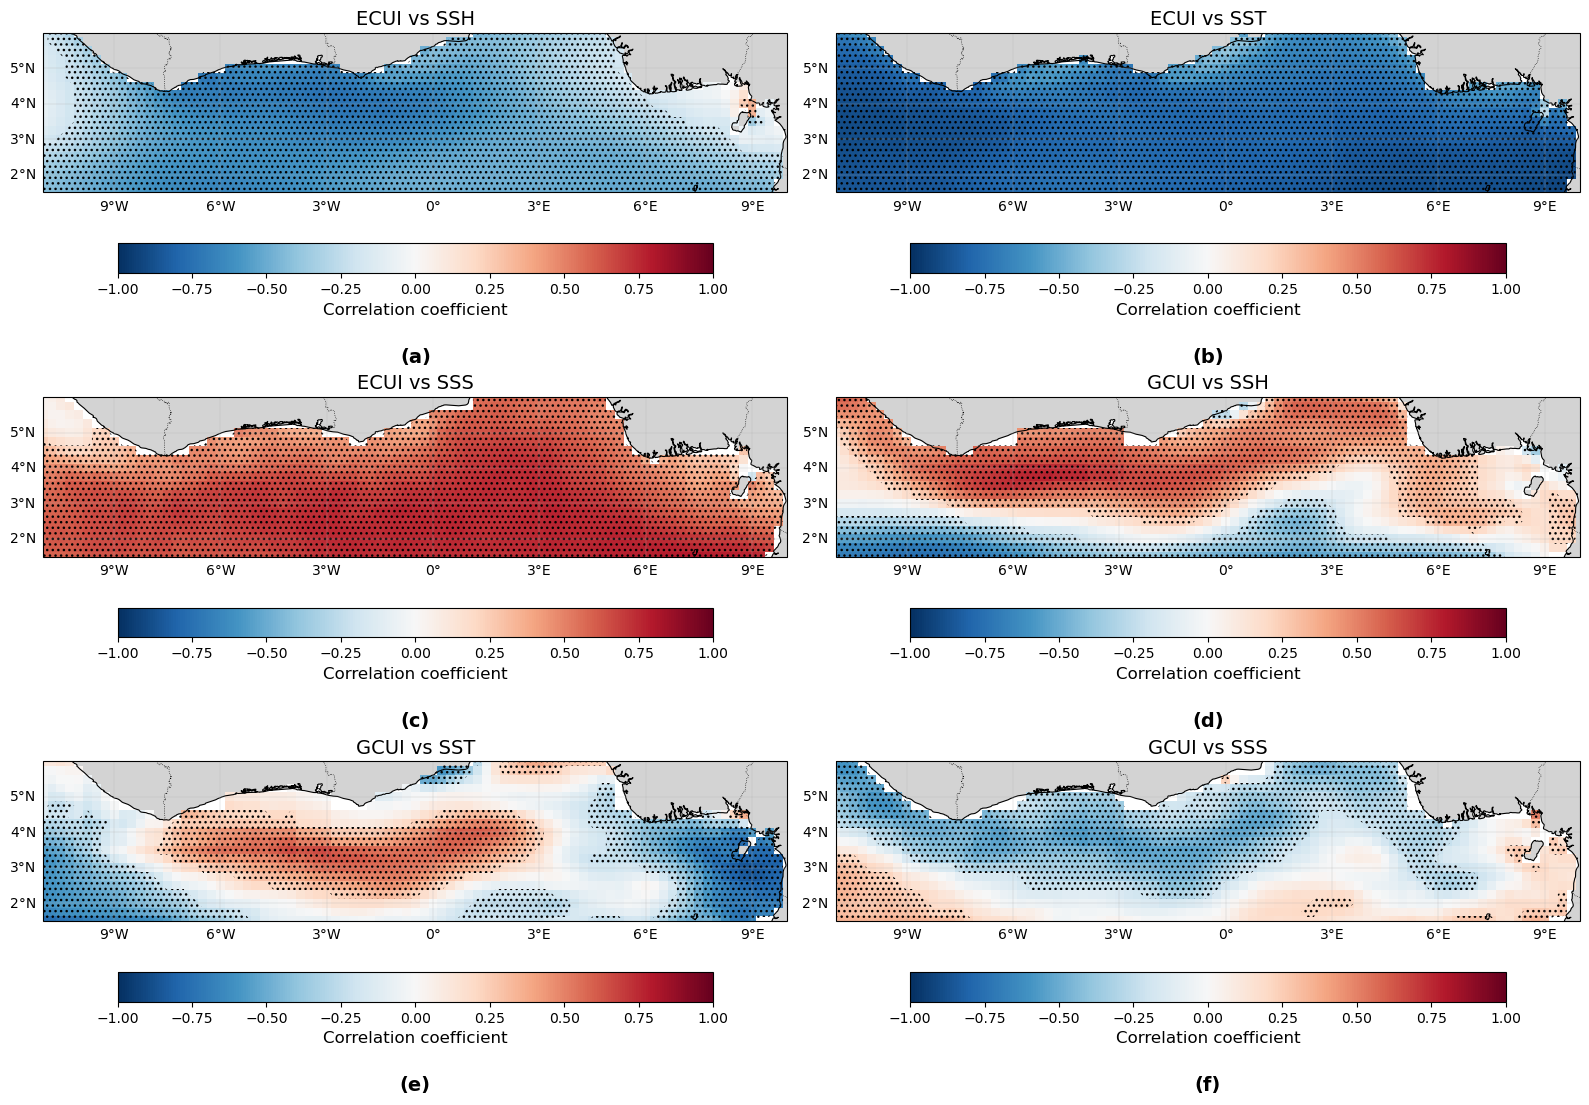

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})

datasets = [
    (correlation_ECUI_SSH, "ECUI vs SSH"),
    (correlation_ECUI_SST, "ECUI vs SST"),
    (correlation_ECUI_SSS, "ECUI vs SSS"),
    (correlation_GCUI_SSH, "GCUI vs SSH"),
    (correlation_GCUI_SST, "GCUI vs SST"),
    (correlation_GCUI_SSS, "GCUI vs SSS"),
]

sig_masks = [
    sig_ECUI_SSH,
    sig_ECUI_SST,
    sig_ECUI_SSS,
    sig_GCUI_SSH,
    sig_GCUI_SST,
    sig_GCUI_SSS,
]

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

for ax, (data, title), sig_mask, label in zip(axes.flat, datasets, sig_masks, labels):
    im = ax.pcolormesh(
        data.longitude, data.latitude, data,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r', vmin=-1, vmax=1, shading='auto'
    )

    # Add significance hatching
    ax.contourf(
        data.longitude, data.latitude, sig_mask,
        levels=[0.5, 1], hatches=['...', None], colors='none',
        transform=ccrs.PlateCarree()
    )

    # Add features and formatting
    ax.coastlines(resolution='10m', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.set_extent([-11, 10, 1.5, 6], crs=ccrs.PlateCarree())
    ax.set_title(title, fontsize=14)
    ax.gridlines(draw_labels={'bottom': 'x', 'left': 'y'}, linewidth=0.2)

    # Colorbar per subplot
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.8)
    cbar.set_label('Correlation coefficient', fontsize=12)

    # Subplot label (a–f)
    cbar.ax.text(
        0.5, -2.5,
        label,
        transform=cbar.ax.transAxes,
        fontsize=14,
        fontweight='bold',
        ha='center', va='top'
    )

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('figures/correlation_1.png', dpi=300)
plt.show()


In [55]:
# -----------------------------------
# Helper Functions for Lag Correlation
# -----------------------------------

def ensure_time_dim(da):
    """
    Ensure a single time-like dimension named 'time'.
    Handles cases where 'time' or 'valid_time' may exist differently across datasets.
    """
    if 'valid_time' in da.coords and 'valid_time' not in da.dims:
        da = da.drop_vars('valid_time')
    if 'time' in da.dims:
        if 'valid_time' in da.coords:
            da = da.drop_vars('valid_time')
        return da
    if 'valid_time' in da.dims:
        if 'time' in da.coords and 'time' not in da.dims:
            da = da.drop_vars('time')
        return da.rename({'valid_time': 'time'})
    raise ValueError("No time-like dimension found (need 'time' or 'valid_time').")


def finite_only(da):
    """Mask out non-finite (NaN or Inf) values."""
    return da.where(np.isfinite(da))


def corr_1d_masked(x, y, min_n=8):
    """
    Compute Pearson correlation and p-value for two 1D arrays,
    while handling missing values.
    """
    m = np.isfinite(x) & np.isfinite(y)
    n = int(m.sum())
    if n < min_n:
        return np.nan, np.nan, n
    r, p = pearsonr(x[m], y[m])
    return r, p, n


def lagged_corr_lon(a, b, lags=np.arange(-6, 7), lat_band=slice(1.5, 6.0), min_n=8):
    """
    Compute lagged correlation between two fields (a, b)
    averaged over a latitude band for each longitude.

    Parameters:
        a, b (xarray.DataArray): Datasets with dims (time, lat, lon)
        lags (array): Lag steps in months (negative = a leads, positive = b leads)
        lat_band (slice): Latitude range to average over
        min_n (int): Minimum valid samples required

    Returns:
        xarray.Dataset with correlation (r), p-values (p), and sample size (n)
        across lag and longitude dimensions.
    """
    # Standardize time dimensions
    a = ensure_time_dim(a); b = ensure_time_dim(b)
    if 'depth' in a.dims: a = a.mean('depth')
    if 'depth' in b.dims: b = b.mean('depth')

    # Average over latitude band
    a = a.sel(latitude=lat_band).mean('latitude')
    b = b.sel(latitude=lat_band).mean('latitude')

    # Align times and mask invalids
    a, b = xr.align(a, b, join='inner')
    a = finite_only(a); b = finite_only(b)

    # Prepare output containers
    lons = a['longitude']
    out_r = xr.full_like(lons, np.nan).expand_dims(lag=lags).astype(float)
    out_p = out_r.copy()
    out_n = xr.full_like(out_r, np.nan).astype(int)

    # Function to compute correlations for a specific lag
    def corr_vs_lon_for_lag(a2d, b2d, L):
        if L > 0:
            aL, bL = a2d, b2d.shift(time=-L)
        elif L < 0:
            aL, bL = a2d.shift(time=+L), b2d
        else:
            aL, bL = a2d, b2d
        aL, bL = xr.align(aL, bL, join='inner')
        aL = finite_only(aL); bL = finite_only(bL)

        r, p, n = xr.apply_ufunc(
            lambda x, y: corr_1d_masked(x, y, min_n=min_n),
            aL, bL,
            input_core_dims=[['time'], ['time']],
            output_core_dims=[[], [], []],
            vectorize=True, dask='parallelized',
            output_dtypes=[float, float, int]
        )
        return r, p, n

    # Loop through lags
    Rs, Ps, Ns = [], [], []
    for L in lags:
        rL, pL, nL = corr_vs_lon_for_lag(a, b, int(L))
        Rs.append(rL); Ps.append(pL); Ns.append(nL)

    out_r.loc[:, :] = xr.concat(Rs, dim='lag').values
    out_p.loc[:, :] = xr.concat(Ps, dim='lag').values
    out_n.loc[:, :] = xr.concat(Ns, dim='lag').values

    return xr.Dataset({'r': out_r, 'p': out_p, 'n': out_n})


In [56]:
# Latitude band (coastal region)
lat_band = slice(1.5, 6.0)

# Lags to test (-6 to +6 months)
lags = np.arange(-6, 7)

# Color scale limit for correlation plots
vlim = 1.0

# Significance marker transparency
sig_alpha = 0.45

# Ensure consistent time dimension across variables
ECUI = ensure_time_dim(ECUI)
GCUI = ensure_time_dim(GCUI)
SSH  = ensure_time_dim(SSH_interp)
SST  = ensure_time_dim(SST_interp)
SSS  = ensure_time_dim(SSS_interp)


In [57]:
# ECUI relationships
ds_ECUI_SST = lagged_corr_lon(ECUI, SST, lags=lags, lat_band=lat_band)
ds_ECUI_SSH = lagged_corr_lon(ECUI, SSH, lags=lags, lat_band=lat_band)
ds_ECUI_SSS = lagged_corr_lon(ECUI, SSS, lags=lags, lat_band=lat_band)

# GCUI relationships
ds_GCUI_SST = lagged_corr_lon(GCUI, SST, lags=lags, lat_band=lat_band)
ds_GCUI_SSH = lagged_corr_lon(GCUI, SSH, lags=lags, lat_band=lat_band)
ds_GCUI_SSS = lagged_corr_lon(GCUI, SSS, lags=lags, lat_band=lat_band)



c:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
c:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
c:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
c:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
c:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
c:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dty

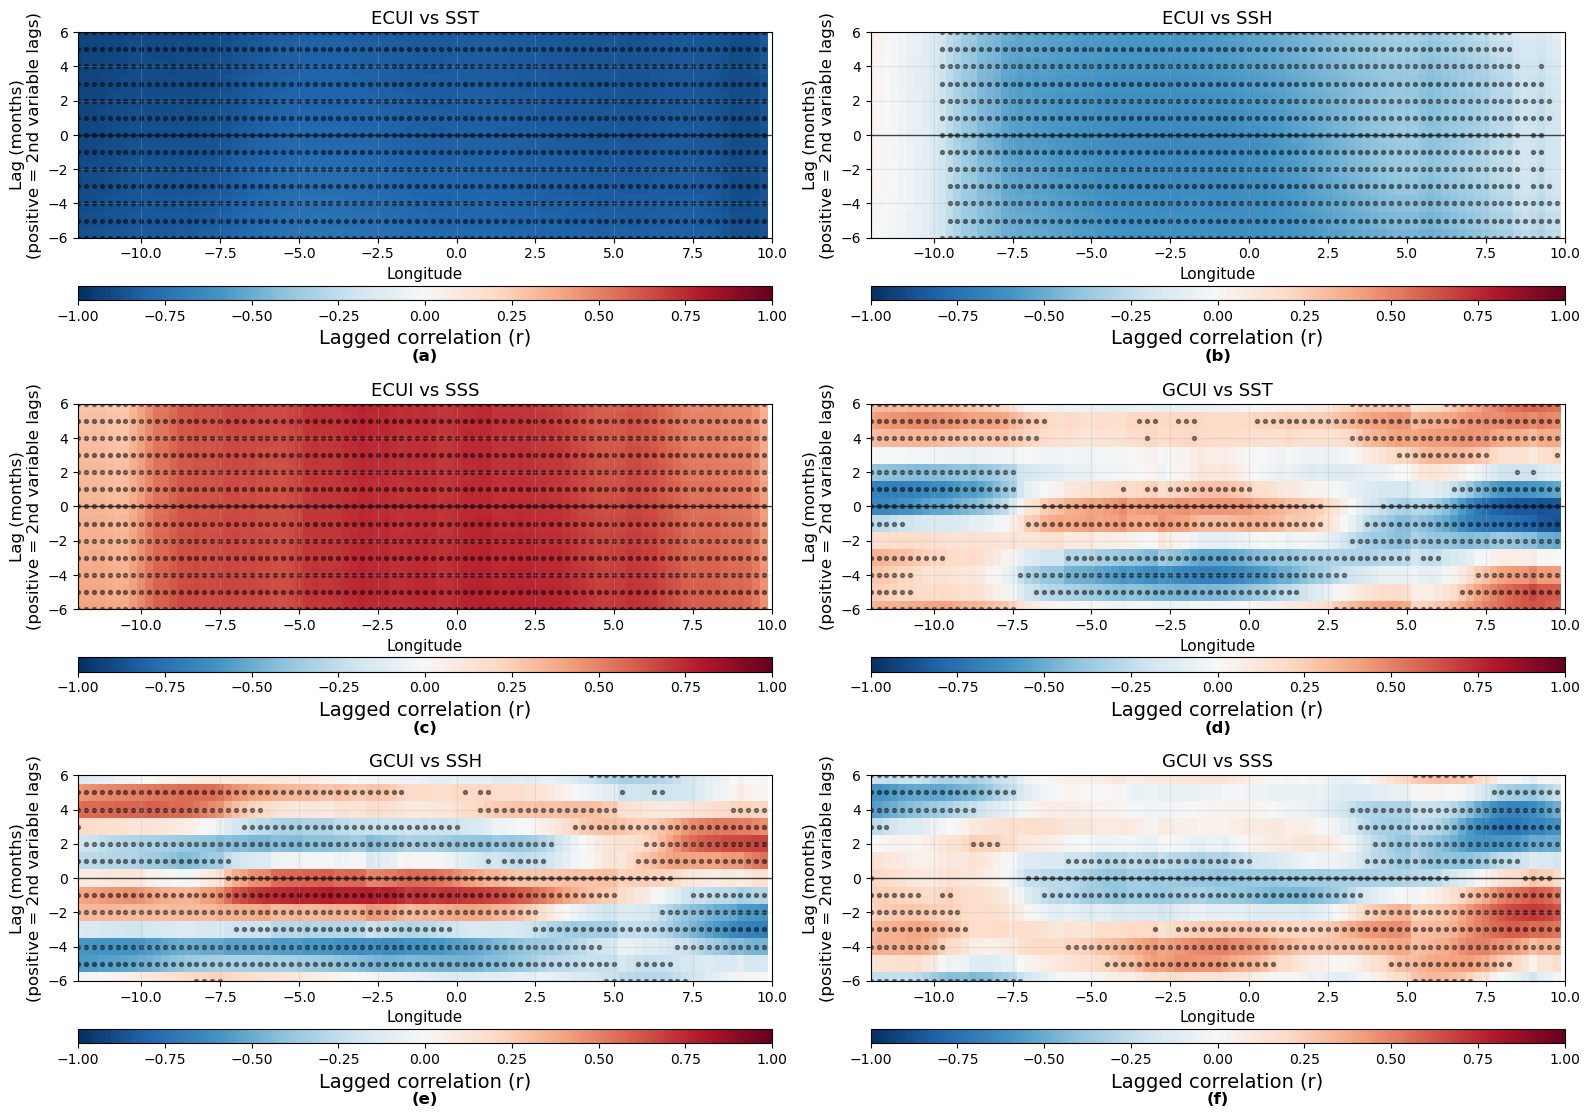

In [58]:
pairs = [
    (ds_ECUI_SST, "ECUI vs SST"),
    (ds_ECUI_SSH, "ECUI vs SSH"),
    (ds_ECUI_SSS, "ECUI vs SSS"),
    (ds_GCUI_SST, "GCUI vs SST"),
    (ds_GCUI_SSH, "GCUI vs SSH"),
    (ds_GCUI_SSS, "GCUI vs SSS"),
]

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

fig, axes = plt.subplots(3, 2, figsize=(16, 12), squeeze=False)

for ax, (dsL, title), label in zip(axes.flat, pairs, labels):
    r = dsL['r']; p = dsL['p']
    lons = r['longitude']; lag_vals = r['lag']

    # Correlation field
    im = ax.pcolormesh(lons, lag_vals, r, cmap='RdBu_r',
                       vmin=-vlim, vmax=vlim, shading='auto')

    # Zero-lag reference line
    ax.axhline(0, color='k', linewidth=1, alpha=0.7)

    # Significance points
    sig = (p < 0.05) & np.isfinite(r)
    XX, YY = np.meshgrid(lons, lag_vals)
    ax.scatter(XX[sig.values], YY[sig.values], s=8, c='k', alpha=sig_alpha)

    # Axis formatting
    ax.set_xlim(float(lons.min()), float(lons.max()))
    ax.set_ylim(lag_vals.min(), lag_vals.max())
    ax.grid(True, alpha=0.25)
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("Longitude", fontsize=11)
    ax.set_ylabel("Lag (months)\n(positive = 2nd variable lags)", fontsize=12)

    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="7%", pad=0.48)
    cb = fig.colorbar(im, cax=cax, orientation='horizontal')
    cb.set_label("Lagged correlation (r)", fontsize=14)

    # Add subplot label
    cb.ax.text(
        0.5, -3.4,
        label,
        transform=cb.ax.transAxes,
        ha='center', va='top',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout(h_pad=1.2, rect=[0, 0.02, 1, 0.96])
plt.savefig("figures/lag_hovmoller_3x2.png", dpi=150)
plt.show()



Explained variance ratio: [0.49936935 0.15106081 0.08858098 0.05036212 0.02693912]


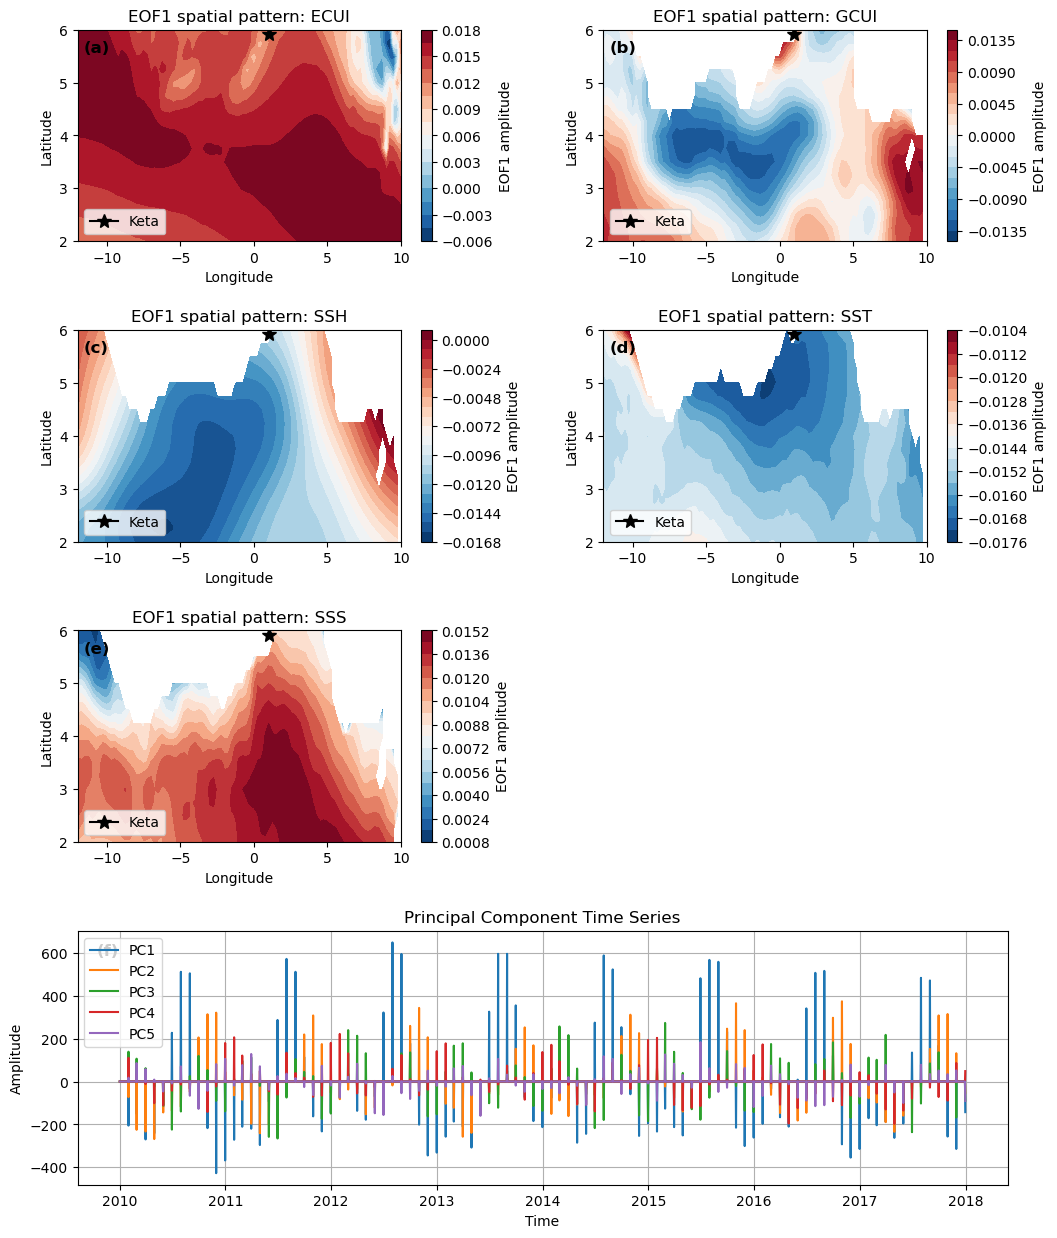

In [61]:
# ======================================================
# EOF / PCA Analysis of Coupled Atmosphere–Ocean Variables
# ======================================================

# PCA here is performed only in the **time domain**, 
# meaning the EOFs capture **temporal covariance among variables** 
# (ECUI, GCUI, SSH, SST, SSS) rather than spatial patterns.


# ------------------------------------------------------
# Load Required Datasets
# ------------------------------------------------------

ssh_ds = xr.open_dataset(ssh_data)
sst_ds = xr.open_dataset(sst_data)
sss_ds = xr.open_dataset(sss_data)


# ------------------------------------------------------
# Subset to Common Time Range (2010–2017)
# ------------------------------------------------------

time_range = slice("2010-01-01", "2017-12-31")

ssh_ds = ssh_ds.sel(time=time_range)
sst_ds = sst_ds.sel(time=time_range)
sss_ds = sss_ds.mean(dim='depth').sel(time=time_range)
cui_ds = cui_ds.sel(time=time_range)

# Extract relevant variables
ECUI = cui_ds['ECUI'] * 86400    # Convert to m/day
GCUI = cui_ds['GCUI'] * 86400
SSH  = ssh_ds['adt']             # Sea Surface Height
SST  = sst_ds['sst']             # Sea Surface Temperature
SSS  = sss_ds['sos']             # Sea Surface Salinity

# ------------------------------------------------------
# Interpolate All Datasets to a Common Grid (CUI grid)
# ------------------------------------------------------

def interp_to_cui(ds, cui_ds):
    """Interpolate dataset to CUI grid for alignment."""
    return ds.interp(latitude=cui_ds.latitude, longitude=cui_ds.longitude, time=cui_ds.time)

SSH_i = interp_to_cui(SSH, cui_ds)
SST_i = interp_to_cui(SST, cui_ds)
SSS_i = interp_to_cui(SSS, cui_ds)

# ------------------------------------------------------
# Ensure Consistent Time Dimension
# ------------------------------------------------------

def ensure_time_dim(da):
    """Standardize datasets to use 'time' as the time-like dimension."""
    if 'valid_time' in da.dims:
        da = da.rename({'valid_time': 'time'})
    return da

ECUI = ensure_time_dim(ECUI)
GCUI = ensure_time_dim(GCUI)
SSH_i = ensure_time_dim(SSH_i)
SST_i = ensure_time_dim(SST_i)
SSS_i = ensure_time_dim(SSS_i)

# ------------------------------------------------------
# Combine Variables into a Single xarray Dataset
# ------------------------------------------------------

ds_combined = xr.Dataset({
    'ECUI': ECUI,
    'GCUI': GCUI,
    'SSH': SSH_i,
    'SST': SST_i,
    'SSS': SSS_i
})

# ------------------------------------------------------
# Optional: Subset Study Region
# ------------------------------------------------------

lat_range = slice(2, 6.0)  # Focus on coastal band
ds_sub = ds_combined.sel(latitude=lat_range)

# ------------------------------------------------------
# Reshape Dataset for PCA
# ------------------------------------------------------

# Convert to numpy array with shape: (time, variable, lat, lon)
data = ds_sub.to_array().transpose("time", "variable", "latitude", "longitude").values
n_time, n_var, n_lat, n_lon = data.shape

# Flatten spatial dimensions: (time, variable * lat * lon)
X_flat = data.reshape(n_time, n_var * n_lat * n_lon)

# ------------------------------------------------------
# Handle Missing Values
# ------------------------------------------------------

# Keep only valid features
valid_features = np.any(np.isfinite(X_flat), axis=0)
X_valid = X_flat[:, valid_features]

# Replace NaNs with mean of each feature
imp = SimpleImputer(strategy="mean")
X_imputed = imp.fit_transform(X_valid)

# ------------------------------------------------------
# Standardize the Data
# ------------------------------------------------------

scaler = StandardScaler()
X_std = scaler.fit_transform(X_imputed)

# ------------------------------------------------------
# Perform PCA
# ------------------------------------------------------

n_components = 5
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_std)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# ------------------------------------------------------
# Map EOFs Back to Original Grid
# ------------------------------------------------------

EOFs_valid = pca.components_  # shape: (n_components, n_valid_features)
EOFs = np.full((n_components, n_var, n_lat, n_lon), np.nan)
EOFs[:, :, :, :].flat[valid_features] = EOFs_valid.flat

# ------------------------------------------------------
# Visualization: EOF Spatial Maps + Principal Components
# ------------------------------------------------------

var_names = list(ds_sub.data_vars)
n_vars = len(var_names)
letters = list(string.ascii_lowercase)

# Create figure layout
fig = plt.figure(figsize=(12, 15))
gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 1.2], hspace=0.4, wspace=0.3)

# Create axes for 3x2 layout (using only 5 subplots for variables)
axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(6)]

# ------------------------------------------------------
# Plot EOF1 Spatial Patterns
# ------------------------------------------------------

for i_var, var_name in enumerate(var_names):
    ax = axes[i_var]
    cs = ax.contourf(ds_sub.longitude, ds_sub.latitude, EOFs[0, i_var],
                     cmap="RdBu_r", levels=21)
    fig.colorbar(cs, ax=ax, orientation="vertical", label="EOF1 amplitude")

    ax.set_title(f"EOF1 spatial pattern: {var_name}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Mark Keta
    ax.plot(0.99, 5.92, marker='*', color='k', markersize=10, label='Keta')
    ax.legend(loc='lower left')

    # Add subplot label (a), (b), (c)...
    ax.text(0.02, 0.95, f"({letters[i_var]})", transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')

# Remove unused subplot
fig.delaxes(axes[5])

# ------------------------------------------------------
# Plot Principal Component (PC) Time Series
# ------------------------------------------------------

ax_pc = fig.add_subplot(gs[3, :])  # full-width bottom row
for i in range(n_components):
    ax_pc.plot(ds_sub.time, X_pca[:, i], label=f"PC{i+1}")

ax_pc.set_title("Principal Component Time Series")
ax_pc.set_xlabel("Time")
ax_pc.set_ylabel("Amplitude")
ax_pc.legend()
ax_pc.grid(True)

# Add subplot label
ax_pc.text(0.02, 0.95, f"({letters[n_vars]})", transform=ax_pc.transAxes,
           fontsize=12, fontweight='bold', va='top', ha='left')

# ------------------------------------------------------
# Save and Display Figure
# ------------------------------------------------------

plt.savefig("figures/all_plots_grid_plus_pc_balanced.png", dpi=300, bbox_inches="tight")
plt.show()
